# Building intuition for compressive learning

This notebook provides a playground to explore the sketched cost.

First, you can chose one (thanks to an simple graphic interface) of three tasks to be solved:
1. k-means with $k = 1$ ("1-means") in dimension $d = 2$
1. k-means with $k = 2$ ("1-means") in dimension $d = 1$
1. GMM modeling with $k = 1$ in dimension $d = 1$

The code will generate a dataset in the relevant dimension. Note that you can generate different datasets by changing the random seed. Moreover, you can also add "extra clusters" in the generated dataset (note that in this case, the value of $k$ used in the cost will not match the truth of the dataset!). When you change the setting, just allow a little bit of time for the figures to be refreshed.

Finally, you can also select the parameters of the sketch: its size ($m$) and the scale parameter ($\sigma$).

In [1]:
%matplotlib notebook

# General imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Interactive widget
from ipywidgets import widgets, interact

# We import the pycle toolbox for sketched learning; we will need three submodules
import pycle
from pycle import sketching, compressive_learning, utils

# Plot utilities
from plot_utils import do_the_plot_for_notebook_2

In [2]:
# f_cost_R is the true statistical learning cost
# f_cost_L is the sketched cost

def f_cost_R(th_0,th_1,X,task):
    if task == '1means2D':
        C = np.array([[th_0,th_1]])   # centroids are of shape d-by-K, here 1-by-2
        return pycle.utils.SSE(X,C)
    elif task == '2means1D':
        C = np.array([[th_0,th_1]]).T # centroids are of shape d-by-K, here 2-by-1
        return pycle.utils.SSE(X,C) 
    elif task == '1GMM1D':
        gmm = (np.array([1.]), np.array([[th_0]]), np.array([[[10**th_1]]]))
        return -pycle.utils.loglikelihood_GMM(gmm,X) 
    
def f_cost_L(th_0,th_1,z,Phi,task):
    if task == '1means2D': 
        sketch_centroids = Phi(np.array([[th_0,th_1]])) 
        return np.linalg.norm(z - sketch_centroids) 
    elif task == '2means1D': # (assumes centroids have equal weights)
        sketch_centroids = 0.5*Phi(np.array([th_0])) + 0.5*Phi(np.array([th_1])) 
        return np.linalg.norm(z - sketch_centroids) 
    elif task == '1GMM1D':
        gmm = (np.array([1.]), np.array([[th_0]]), np.array([[[10**th_1]]]))
        sketch_gaussian = pycle.sketching.fourierSketchOfGMM(gmm,Phi)
        return np.linalg.norm(z - sketch_gaussian) 


<IPython.core.display.Javascript object>


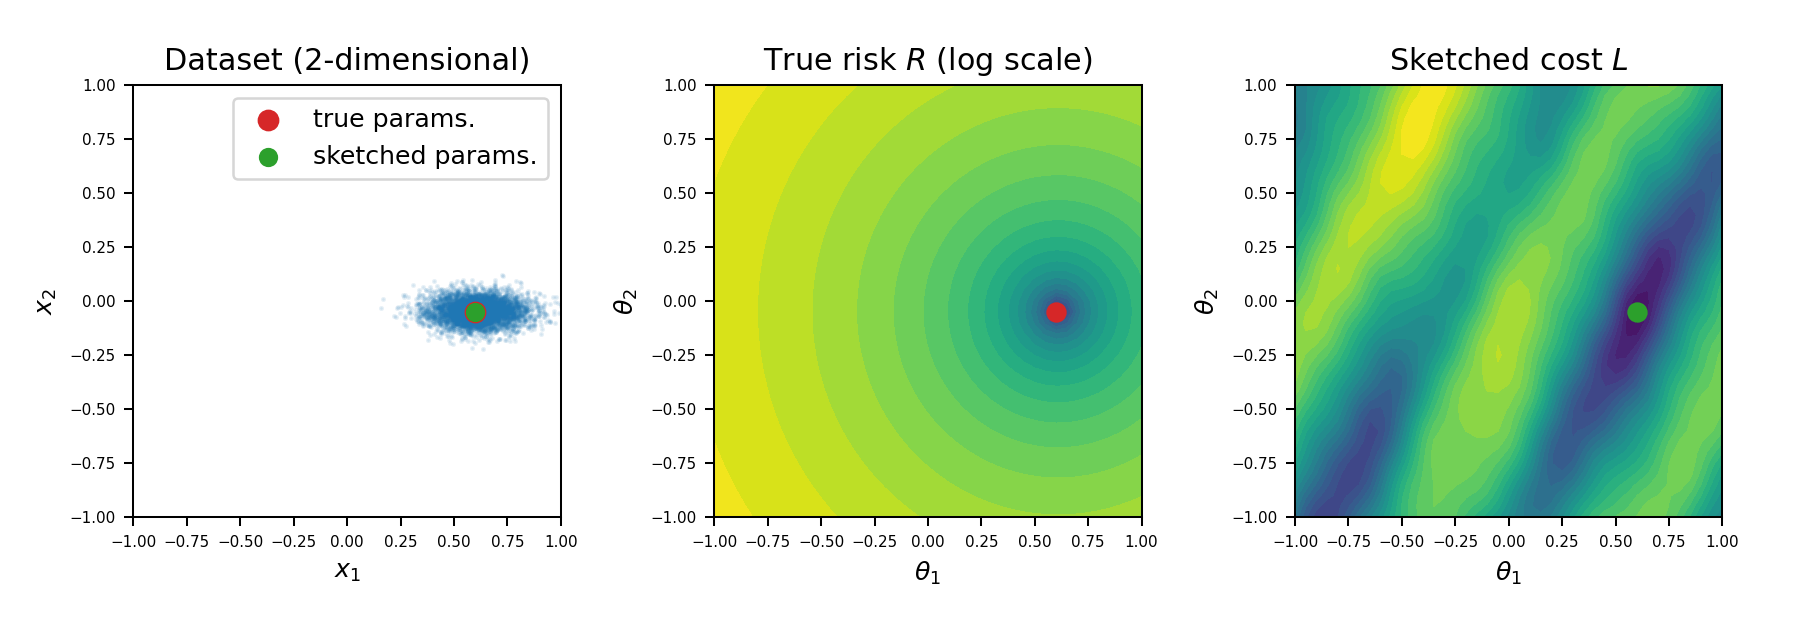

interactive(children=(Dropdown(description='task', options={'1means2D': '1means2D', '2means1D': '2means1D', '1…

In [3]:
tasks = {
    '1means2D': '1means2D',
    '2means1D': '2means1D',
    '1GMM1D':   '1GMM1D'
}
seeds  = widgets.IntSlider(value=42, min=0, max=100,step=1, description='random seed', continuous_update=False)
extra_ks  = widgets.IntSlider(value=0, min=0, max=2,step=1, description='extra clusters', continuous_update=False)

ms     = widgets.FloatLogSlider(value=10, min=0, max=3,step=0.1, description='$m$', continuous_update=False)
sigmas = widgets.FloatLogSlider(value=0.1,min=-3,max=2,  step=0.1, description='$\sigma$', continuous_update=False)

#plt.ion()
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.tight_layout(pad=3)

ballsize = 50
markersize = 20
lw = 1.5
cL = 'tab:green'
cR = 'tab:red'

ticksize = 6
plt.rc('xtick',labelsize=ticksize)
plt.rc('ytick',labelsize=ticksize)

@interact(task=tasks,seed=seeds,extra_k=extra_ks,m=ms,sigma=sigmas)
def _(task,seed,extra_k,m,sigma):
    
    if task == '1means2D':
        d = 2
        k = 1
    elif task == '2means1D':
        d = 1
        k = 2
    elif task == '1GMM1D':
        d = 1
        k = 1
    
    m = int(m)
    print("sketch size m = " + str(m))
    
    # Print params
    if task == '1means2D':
        print(r"task: 1-means in 2d, centroid: c_1 = (theta_1,theta_2)")
    elif task == '2means1D':
        print(r"task: 2-means in 1d, centroids: c_1 = theta_1, c_2 = theta_2")
    elif task == '1GMM1D':
        print(r"task: fitting one Gaussian in 1d, GMM: N(mu = theta_1,sigma^2 = theta_2)")
    
    np.random.seed(seed)
    n = int(5e3) # Number of samples we want to generate
    X = pycle.utils.generatedataset_GMM(d,k+extra_k,n,normalize='l_inf-unit-ball',balanced=False, separation_min=2) 
    
    # Sketch
    sigma2 = sigma**2

    W = pycle.sketching.drawFrequencies("Gaussian",d,m,sigma2)
    Phi = pycle.sketching.SimpleFeatureMap("ComplexExponential",W)
    z = pycle.sketching.computeSketch(X,Phi)
    
    # Bounds
    low_pos = -1
    upp_pos = +1
    low_var = -3 # in log10 scale
    upp_var = 0  # in log10 scale

    nTest = 41

    # Params to test
    if task == '1means2D' or task == '2means1D':
        thetas_00 = np.linspace(low_pos,upp_pos,nTest)
        thetas_11 = np.linspace(low_pos,upp_pos,nTest)
        pos_fine = None
    elif task == '1GMM1D':
        thetas_00 = np.linspace(low_pos,upp_pos,nTest)
        thetas_11 = np.linspace(low_var,upp_var,nTest)
        pos_fine = np.linspace(low_pos,upp_pos,5*nTest) # to evaluate the pdf
    thetas_0,thetas_1 = np.meshgrid(thetas_00,thetas_11) 
    
    # Compute the costs everywhere
    cost_R = np.zeros((nTest,nTest))
    cost_L = np.zeros((nTest,nTest))

    # Exhaustive loop over the grid
    for i_0,th_0 in enumerate(thetas_00):
        for i_1,th_1 in enumerate(thetas_11):
            cost_R[i_0,i_1] = f_cost_R(th_0,th_1,X,task)
            cost_L[i_0,i_1] = f_cost_L(th_0,th_1,z,Phi,task)

    # Call the dedicated plotting subroutine from plot_utils.py
    do_the_plot_for_notebook_2(task,d,ax1,ax2,ax3,thetas_0,thetas_1,X,cost_L,cost_R,ballsize,cR,cL,markersize,lw,pos_fine)

